# Diffusion models

## Introduction

Recently, diffusion models have emerged as the top contender for generative models. Let us explore diffusion models and get some intuition on how they work.

## Preparing the dataset

let us load `torch` as well as some data to approximate. For our purposes, we will use the MNIST dataset

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torchvision
import torchvision.datasets as datasets

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['figure.dpi'] = 100

In [2]:
# enable GPU training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)

Let us visualize some examples from the dataset:

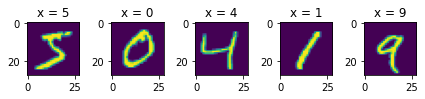

In [4]:
fig = plt.figure()
for i in range(0,5):
    ax = plt.subplot(1,5,i+1)
    data = mnist_trainset[i]
    ax.imshow(data[0])
    ax.set_title(f"x = {data[1]}")
fig.tight_layout()

## Preliminaries

generative model, i.e. we want to approximate $p(x)$ using some learned distribution $p_\theta(x)$.
### Forward diffusion process
Let $x_0 \sim q(x)$ be a data point sampled from some distribution. We define the _forward_ diffusion proces, in which we add a small amount of Gaussian noise to the sample. We repeat this $T$ times, which gives us the sequen_channelse of noisy samples $x_1, x_2, \dots, x_T$. The varian_channelse at each step is controlled at each step $t$ by some $\beta_t \in (0,1)$, such that

$$
q(x_t \vert x_{t-1}) = \mathcal{N} (x_t \vert \sqrt{1 - \beta_t} x_{t-1}, \beta_t I).
$$

In other words, at each diffusion step, the conditional distribution $q(x_t \vert x_{t-1})$ is a gaussian with isotropic varian_channelse $\beta_t$ and mean $\sqrt{1 - \beta_t} x_{t-1}$. In the limit $T \rightarrow \infty$, the distribution approaches uniform Gaussian noise, i.e. $x_T \sim \mathcal{N}(0, I)$.

A useful identity is to reparametrize these distributions in terms of $\alpha_t = 1 - \beta_t$ and $\bar{\alpha}_t = \prod_{i=1}^T \alpha_i$. Introducing $z_{t-1}, z_{t-2}, \dots \sim \mathcal{N}(0,1)$, we get

$$
\begin{align*}
x_t &= \sqrt{\alpha_t} x_{t-1} + \sqrt{1 - \alpha_t} z_{t-1} \\
&= \sqrt{\alpha_t \alpha_{t-1}} x_{t-2} + \sqrt{1 - \alpha_t} \bar{z}_{t-2} \\
&= \dots \\
&= \sqrt{\bar{\alpha}_t} x_{0} + \sqrt{1 - \bar{\alpha}_t} z
\end{align*}
$$

Here we have also introduced $\bar{z}_{t-2}$, which merges two Gaussian random variables as a new Gaussian random variable with variance $(1 - \alpha_t) + \alpha_t (1 - \alpha_{t-1}) = 1 - \alpha_t \alpha_{t-1}$. As a consequence, we have

$$
q(x_t \vert x_0) = \mathcal{N}(x_t \vert \sqrt{\bar{\alpha}_t} x_0, (1 - \bar{\alpha}_t) I).
$$

### Langevin dynamics

The concept of Langevin dynamics allows us to generate samples from a distribution $p(x)$, only using the gradients $\nabla_{x} \log p\left(x_{t-1}\right)$.

$$
x_{t}=x_{t-1}+\frac{\epsilon}{2} \nabla_{x} \log p\left(x_{t-1}\right)+\sqrt{\epsilon} z_{t}, \quad \text{where} z_{t} \sim \mathcal{N}(0, I)
$$

When $T \rightarrow \infty$, $x_T \sim p(x)$.

### Reverse diffusion process
We would like to reverse the diffusion process and sample from $q(x_{t-1} \vert x_t)$, starting from a Gaussian noise input $x_T \sim \mathcal{N}(0, I)$. An import observation is that for sufficiently small $\beta_t$, $q(x_{t-1} \vert x_t)$ will also be Gaussian. To estimate it, we would need to use the entire dataset, which is unpractical, so instead we train a model 

$$
p_\theta(x_{t-1} \vert x_t) = \mathcal{N}(x_{t-1} \vert \mu_\theta(x_t, t), \Sigma_\theta(x_t, t)),
$$

to approximate $q(x_{t-1} \vert x_t)$.

An important property is that $q\left(x_{t-1} \mid x_{t}, x_{0}\right)$ becomes tractable when conditioned on $x_0$:

$$
\begin{align*}
q\left(x_{t-1} \mid x_{t}, x_{0}\right) &=q\left(x_{t} \mid x_{t-1}, x_{0}\right) \frac{q\left(x_{t-1} \mid x_{0}\right)}{q\left(x_{t} \mid x_{0}\right)} \\
&\dots \\
&\propto\exp \left(-\frac{1}{2}\left(\left(\frac{\alpha_{t}}{\beta_{t}}+\frac{1}{1-\bar{\alpha}_{t-1}}\right) x_{t-1}^{2}-\left(\frac{2 \sqrt{\alpha_{t}}}{\beta_{t}} x_{t}+\frac{2 \sqrt{\bar{\alpha}_{t-1}}}{1-\bar{\alpha}_{t-1}} x_{0}\right) x_{t-1}+C\left(x_{t}, x_{0}\right)\right)\right),
\end{align*}
$$

where $C(x_{t}, x_{0})$ is some function that does not depend on $x_{t-1}$ and therefore a constant term in the distribution. We can rewrite all of this and identify that this is a Gaussian with mean and variance

$$
\begin{align*} \tilde{\beta}_{t} &=\frac{1-\bar{\alpha}_{t-1}}{1-\bar{\alpha}_{t}} \cdot \beta_{t} \\
\tilde{\mu}_{t}\left(x_{t}, x_{0}\right) &=\frac{\sqrt{\alpha_{t}}\left(1-\bar{\alpha}_{t-1}\right)}{1-\bar{\alpha}_{t}} x_{t}+\frac{\sqrt{\bar{\alpha}_{t-1}} \beta_{t}}{1-\bar{\alpha}_{t}} x_{0}
\end{align*}
$$

This seems preblematic, as we still do not know, $x_{0}$, but thanks to the reparametrization trick, we can plug in $x_{0}=\frac{1}{\sqrt{\bar{\alpha}_{t}}}\left(x_{t}-\sqrt{1-\bar{\alpha}_{t}} z_{t}\right)$, which then yields 

$$
\tilde{\mu}_{t}
% =\frac{\sqrt{\alpha_{t}}\left(1-\bar{\alpha}_{t-1}\right)}{1-\bar{\alpha}_{t}} x_{t}+\frac{\sqrt{\bar{\alpha}_{t-1}} \beta_{t}}{1-\bar{\alpha}_{t}} \frac{1}{\sqrt{\bar{\alpha}_{t}}}\left(x_{t}-\sqrt{1-\bar{\alpha}_{t} z_{t}}\right)
=\frac{1}{\sqrt{\alpha_{t}}}\left(x_{t}-\frac{\beta_{t}}{\sqrt{1-\bar{\alpha}_{t}}} z_t\right).
$$

For training, we can use a similar setup to what is done in other generative models, such as VAEs.

![](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/DDPM.png)

## In practice

the algorithms for sampling and training the model can be summarized as follows:

![](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/DDPM-algo.png)

### Defining samplers
define sampler for the dataset

In [5]:
def sample_mnist(batch_size):
    dataset = torchvision.datasets.MNIST(root = './data/', train = True, download = True)
    result = dataset.data[:batch_size].to(device).view(-1, 1, 28, 28).float()
    return result

n_samples = 65536
training_data = sample_mnist(n_samples)

In [6]:
training_data.shape

torch.Size([60000, 1, 28, 28])

For normalization we require the mean and standard deviation of out dataset:

In [7]:
training_mean, training_std = training_data.mean(), training_data.std()

### Define the model

We define the model, which will approximate the denoising distribution:

In [8]:
class ConvNet(nn.Module):

    def __init__(self, in_channels, out_channels):

        super().__init__()
        
        kernel_size = 5
        n_channels = 64
        
        self.core = nn.Sequential(
            nn.Conv2d(in_channels + 1, n_channels, kernel_size, padding = kernel_size//2),
            nn.ReLU(),
            nn.Conv2d(n_channels, n_channels, kernel_size, padding = kernel_size//2),
            nn.ReLU(),
            nn.Conv2d(n_channels, n_channels, kernel_size, padding = kernel_size//2),
            nn.ReLU(),
            nn.Conv2d(n_channels, n_channels, kernel_size, padding = kernel_size//2),
            nn.ReLU(),
            nn.Conv2d(n_channels, n_channels, kernel_size, padding = kernel_size//2),
            nn.ReLU(),
            nn.Conv2d(n_channels, out_channels, kernel_size, padding = kernel_size//2),
        )
    
    def forward(self, input):
        x, t = input
        if not torch.is_tensor(t):
            t = x.new_full((x.size(0),), t)
        t = t.view((-1,) + (1,) * (x.dim() - 1)).expand_as(x[:,:1])
        return self.core(torch.cat((x, t), 1))

model = ConvNet(training_data.size(1), training_data.size(1))
model.to(device)

ConvNet(
  (core): Sequential(
    (0): Conv2d(2, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): ReLU()
    (8): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (9): ReLU()
    (10): Conv2d(64, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
)

### Training the model

wewill use ADAM to optimize our model. Let us first determine the hyperparameters as they were defined in Ho et al.:

In [9]:
T = 1000
beta = torch.linspace(1e-4, 0.02, T, device=device)
alpha = 1 - beta
alpha_bar = alpha.log().cumsum(0).exp()
sigma = beta.sqrt()

In [10]:
n_epochs = 100
learning_rate = 1e-3
batch_size = 32
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

for epoch in range(n_epochs):

    acc_loss = 0

    for x0 in training_data.split(batch_size):
        x0 = (x0 - training_mean) / training_std
        t = torch.randint(T, (x0.size(0),) + (1,) * (x0.dim() - 1), device = x0.device)
        eps = torch.randn_like(x0)
        xt = torch.sqrt(alpha_bar[t]) * x0 + torch.sqrt(1 - alpha_bar[t]) * eps
        output = model((xt, t / (T - 1) - 0.5))
        loss = (eps - output).pow(2).mean()
        acc_loss += loss.item() * x0.size(0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'epoch: {epoch} loss: {acc_loss / training_data.size(0)}')


epoch: 0 loss: 0.09506426229774952
epoch: 1 loss: 0.0496705472479264
epoch: 2 loss: 0.10015559994379679
epoch: 3 loss: 0.05478452536761761
epoch: 4 loss: 0.04774375363787015
epoch: 5 loss: 0.04534570259451866
epoch: 6 loss: 0.04311676119367282
epoch: 7 loss: 0.042586187487840654
epoch: 8 loss: 0.0409397339651982
epoch: 9 loss: 0.04011734099388123
epoch: 10 loss: 0.040205454724033675
epoch: 11 loss: 0.03942767694393794
epoch: 12 loss: 0.03904419451653957
epoch: 13 loss: 0.03864361907740434
epoch: 14 loss: 0.03888168223897616
epoch: 15 loss: 0.037786284789443014
epoch: 16 loss: 0.03785478172997633
epoch: 17 loss: 0.03710315034488837
epoch: 18 loss: 0.03717351695100466
epoch: 19 loss: 0.03745960584133864
epoch: 20 loss: 0.03662767000446717
epoch: 21 loss: 0.03685322531958421
epoch: 22 loss: 0.03672707702269157
epoch: 23 loss: 0.03658906747748454
epoch: 24 loss: 0.03672267760634422
epoch: 25 loss: 0.03638336846381426
epoch: 26 loss: 0.036482974069317185
epoch: 27 loss: 0.036188600547611714

### Sampling the model

In [15]:
def sample_model(size, T, alpha, alpha_bar, sigma, model, train_mean, train_std):

    with torch.no_grad():

        x = torch.randn(size, device=device)

        for t in range(T-1, -1, -1):
            output = model((x, t / (T - 1) - 0.5)) # essentially z_\theta
            z = torch.zeros_like(x) if t == 0 else torch.randn_like(x)
            x = ( 1 / torch.sqrt(alpha[t]) ) * (x - (1-alpha[t]) / torch.sqrt(1-alpha_bar[t]) * output) + sigma[t] * z

        x = x * train_std + train_mean

        return x


In [17]:
x = sample_model((32,) + training_data.size()[1:], T, alpha, alpha_bar, sigma, model, training_mean, training_std)

x.shape


torch.Size([32, 1, 28, 28])

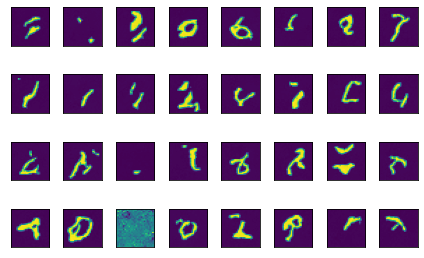

In [16]:
fig = plt.figure()
for i in range(0,32):
    ax = plt.subplot(4,8,i+1)
    data = mnist_trainset[i]
    ax.imshow(x[i].cpu().squeeze())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
fig.tight_layout()

Still not great, but also not bad for a first model. Others have done much better...

## References

* [_What are Diffusion models?_; Lilian Weng](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/)
* [_Denoising Diffusion Probabilistic Models_; Jonathan Ho, Ajay Jain, Pieter Abbeel](https://arxiv.org/abs/2006.11239)
* [_High-Resolution Image Synthesis with Latent Diffusion Models_; Robin Rombach, Andreas Blattmann, Dominik Lorenz, Patrick Esser, Björn Ommer](https://arxiv.org/abs/2112.10752)
* [https://fleuret.org/francois/materials.html](https://fleuret.org/francois/materials.html)
* [karpathy/stablediffusionwalk.py](https://gist.github.com/karpathy/00103b0037c5aaea32fe1da1af553355)
